# EIP-1559: A transaction fee market proposal

###### March 2020, [@barnabemonnot](https://twitter.com/barnabemonnot)
###### [Robust Incentives Group](https://github.com/ethereum/rig), Ethereum Foundation

---

EIP-1559 is perhaps one of the most anticipated upgrades to the economic model of Ethereum. Proposed by Vitalik Buterin in his [Blockchain Resource Pricing](https://github.com/ethereum/research/blob/master/papers/pricing/ethpricing.pdf) paper, the mechanism seeks to replace the first-price auction model governing the current fee market for transaction inclusion.

## Why EIP-1559?

### Transactions 101

Users submit _transactions_ to interact with a blockchain. In Ethereum, these transactions can be as simple as sending ether from one account to another, or as complex as making a contract perform something on your behalf (entering a lottery, executing a trade etc). In the latter case, your transaction might trigger other transactions to execute, cascading until no more side-effects take place. It is clear that the simple transfer is much less computation than a complex, multistage transaction, so we measure how much resources each transaction requires by how much _gas_ the transaction (and its potential cascading transactions) needs to execute.

The Ethereum Virtual Machine (EVM), which processes these transactions, has a cost in gas for each elementary operation: adding numbers, storing a value, transfering ether. All transactions are made up of an arbitrary number of these elementary operations (even the really complex ones!) Together, these elementary operations tally up to the gas necessary to process the entire transaction.

|| Transaction operations | Gas |
|-|-|-|
|1| Add | 20 |
|2| Transfer | 100 |
||**Transaction total** | 120 |

But space is few, as blocks are produced on a regular interval and offer only a limited amount of available gas. To avoid congestion, transaction senders ("users") price the gas they seek to use, e.g., specifying that they are ready to pay 6 Gwei per unit of gas to have their transaction included.

| Transaction gas | Gas price (Gwei) | Total fee (Gwei) |
|-|-|-|
| 120 | 6 | 720 |

### Auctions as market mechanism

In the current auction model, block producers typically select a set of the highest paying transactions, making sure that the total gas required by all transactions in the set does not exceed the limit amount of gas offered in a block. Users with selected transactions end up paying the gas price they specified, times the amount of gas their transaction required to be processed. Thus, users "pay what they bid": this is a first-price auction.

In the following table, we assume the block gas limit is 1,000. Though there is a transaction (the last one) paying out 700 Gwei, the block producer cannot include it as it would break the gas limit and thus prefers to include the first, 720 Gwei-valued, transactions. Users pay exactly the fee stated in the column.

| Transaction gas | Gas price (Gwei) | Total fee (Gwei) | Included? | Cumulative gas |
|-|-|-|-|-|
| 120 | 6 | 720 | Yes | 120 |
| 200 | 5 | 1000 | Yes | 320 |
| 700 | 1 | 700 | No | 320 |

The first-price auction has many defects. In its simplest theoretical model, where users bid simultaneously and privately, it is a well-known result that first-price auction are not incentive-compatible, meaning that users do not have the incentive to bid their true value for the transaction being included. Second-price auctions are though, when the winner of the auction pays the bid offered by the second-highest bidder.

So second-price auctions were considered as an alternative, but where we may hold Sotheby's accountable for manipulating the result of an auction, we can't quite always do that in the blockchain setting. Since block producers have the final say on who gets included or not, they can "stuff" the blocks with phony transactions from themselves to pump up the "second price", and thus trick the protocol into giving them more than what the market should offer while leaving honest fee-paying transactions by the curb ([this can be somewhat mitigated](https://arxiv.org/abs/1901.06830)).

### Pricing congestion and EIP-1559

Enters EIP-1559, written up in an [Ethereum improvement protocol (EIP) suggestion by Eric Conoar of EthHub fame and Buterin himself](https://eips.ethereum.org/EIPS/eip-1559). The proposal involves setting a variable _basefee_ to be paid by anyone who wishes to have a transaction included, with the base fee varying according to how empty or how full blocks are. The block limit is set to a fairly high value, while the EIP-1559 mechanism targets a fixed _block size_ ([the amount of gas spent by transactions in the block](https://ethgasstation.info/blog/ethereum-block-size/)).

In dire times, when everyone is trying to upgrade their CryptoKitty or frantically closing out their debt positions, block sizes increase as more users are willing to pay the current basefee. In this case, the mechanism increases the basefee to price out users who just don't want it bad enough, returning block sizes to their fixed target. Alternatively, when the chain is an open empty road to nowhere, we would prefer to encourage users to send their transactions in for cheap, so basefee should be much lower.

Under the auction market though, if a lot of people want to transact on the chain at the same time, the threshold bids making it into the blocks should steadily increase (and indeed, have done so in the past). Isn't that the same outcome as EIP-1559? Complicating things, we'll also see in our simulations that users can specify a "tip" paid out to the block producers, in addition to the basefee. A higher tip gets you to the end of the line faster, kind of like the auction mechanism does already. So why do we care about a mechanism seemingly not so different from the auction?

| Basefee (burned) | Tip (paid to block producer) | Total fee |
|-|-|-|
| 4 | 1 | 5 |

One clue is predictability. First-price auctions are notoriously hard to analyse even in the best of cases. It gets worse when bids are open (as they are to anyone who listens to the _mempool_ where user transactions languish before being included) and replaceable (as they are, though not so trivially, with transaction-replacement operations). There is hope that a more "algorithmic" price discovery mechanism will help remove this variability, even when demand fluctuates swiftly (we'll see some of that in the simulations below).

Another clue is analytic simplicity. Pricing things, and especially congestion, in the most parsimonious manner is one object of algorithmic game theory, which is the study of mechanisms from the computational lens. We know from Pigou, Vickrey and a long line of economists that we usually like to _internalise externalities_, i.e., make people pay for not only what they are doing _for_ themselves, but also what they are doing _to_ others.

When I am on the road in the morning, I impose my presence to everyone else also on the road, and vice-versa. This is why the most fundamental result in this corner of the discipline states that the correct price to pay for people cramming in some resource is exactly the _marginal price_: the price of the extra inconvenience for everyone else that your presence imposes. With first-price auctions, it is not clear that we ever get to that price. But a mechanism seeking to achieve some target (e.g., the amount of gas used by a block) and raising/lowering the price (e.g., the basefee) to meet that target gets much closer to this marginal price. And if that is simpler for us to analyse, that also means we get to predict a bit better how the mechanism will behave. Double whammy!

But ok, after this long intro, let's dive into the mechanics of the... ahem... mechanism. We'll first set up a simple cadCAD environment and progressively add on to it to simulate more and more complex phenomena.

## The environment

First, we define a simple `Transaction` class, as these are the base element of our simulation. Users produce transactions, which are sent to block producers who must select which of these transactions to include. Under EIP-1559, users specify two things:

- The _gas premium_, i.e., the "tip" to the block producers.
- The _fee cap_, i.e., the highest gas price they are willing to pay.

As before, users also specify a gas limit for their transaction. If the transaction ends up consuming more gas than the specified gas limit, it is reverted without changes to the chain.

In [1]:
class Transaction:
    def __init__(self, gas_premium, fee_cap, gas_used):
        self.gas_premium = gas_premium
        self.fee_cap = fee_cap
        self.gas_used = gas_used

Second, we'll grab a few constants from the EIP, possibly looking to change them later on.

In [2]:
constants = {
    "BASEFEE_MAX_CHANGE_DENOMINATOR": 8,
    "TARGET_GAS_USED": 10000000,
    "MAX_GAS_EIP1559": 16000000,
    "EIP1559_DECAY_RANGE": 800000,
    "EIP1559_GAS_INCREMENT_AMOUNT": 10,
    "INITIAL_BASEFEE": 1000000000,
    "PER_TX_GASLIMIT": 8000000
}

Remember that we set up our cadCAD simulations as a repeating pattern of state updates and policies. For this simulation, here is our plan:

1. **(State update)** `update_demand`: Users generate some demand, a list of transactions added to the mempool.
2. **(Policy)** `include_all_txs`: We have more space to define what our policies are. For now, our block producers will include all transactions in the mempool inside their blocks (we'll make sure that the total amount of gas required won't exceed the gas limit in blocks).
3. **(State update)** `update_basefee`: Given the included transaction, the protocol checks whether the basefee needs to be updated or not. We'll go deeper into how this update works later on, for now, simply keep in mind that the fee should decrease as our blocks won't be full.

In [3]:
def update_demand(params, step, sL, s, _input):
    basefee = s["basefee"]
    demand = [Transaction(
        gas_premium = 1000000000,
        gas_used = 21000,
        fee_cap = 6000000000
    ) for i in range(100)]
    return ("demand", demand)
    
def include_all_txs(params, step, sL, s):
    demand = s["demand"]
    basefee = s["basefee"]
    miner_gains = 0
    total_gas_used = 0
    
    for tx in demand:
        gas_price = min([basefee + tx.gas_premium, tx.fee_cap])
        fee = gas_price * tx.gas_used
        miner_gains += (gas_price - basefee) * tx.gas_used
        total_gas_used += tx.gas_used
        
    assert miner_gains >= 0
    return ({ "gas_used": total_gas_used })
    
def update_basefee(params, step, sL, s, _input):
    gas_used = _input["gas_used"]
    delta = gas_used - constants["TARGET_GAS_USED"]
    basefee = s["basefee"]
    new_basefee = basefee + basefee * delta // constants["TARGET_GAS_USED"] // constants["BASEFEE_MAX_CHANGE_DENOMINATOR"]
    return ("basefee", new_basefee)

psub = [{
    "policies": {},
    "variables": {
        "demand": update_demand # step 1
    }
}, {
    "policies": {
        "action": include_all_txs # step 2
    },
    "variables": {
        "basefee": update_basefee # step 3
    }
}]

We set our initial conditions: an empty demand and basefee starting from the EIP-defined constant `INITIAL_BASEFEE`.

In [4]:
initial_conditions = {
    "basefee": constants["INITIAL_BASEFEE"],
    "demand": []
}

Set up our simulation parameters: for now we will run the simulation for 300 steps (i.e., 300 blocks).

In [5]:
simulation_parameters = {
    'T': range(100),
    'N': 1,
    'M': {}
}

And finally set up and execute the simulation!

In [6]:
%%capture

from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd

config = Configuration(initial_state=initial_conditions,
                       partial_state_update_blocks=psub,
                       sim_config=simulation_parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results
df = pd.DataFrame(raw_result)

OK! Our results are in `df`, so let's plot the `basefee` and see how that evolved.

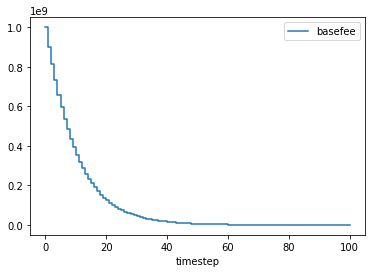

In [7]:
df.plot('timestep', ['basefee'])

Unsurprisingly, `basefee` decreases, in fact decreases quite fast to stabilise around just a few weis. We'll talk about the dynamics of basefee more when we dig into how the update is done.

### Refining the demand

Realistically though, our demand is not uniform at all. Some users will make a killing on Uniswap so would be happy to pay a high fee to have their transaction go through fast, while others are content to wait a bit longer should the entry price be too high. We'll refine the previous example a bit by adding some variability in the user transactions. We'll keep the gas used homogenous, just to avoid solving complex set-packing problems.

In [8]:
from random import randint

def update_demand_variable(params, step, sL, s, _input):
    basefee = s["basefee"]
    demand = []
    for i in range(100):
        gas_premium = randint(1, 10) * 1000000000
        fee_cap = gas_premium + randint(1, 10) * 1000000000
        demand += [Transaction(
            gas_premium = gas_premium,
            gas_used = 21000,
            fee_cap = fee_cap
        )]
    return ("demand", demand)

Let's look into our demand a bit.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a767390>,
      dtype=object)

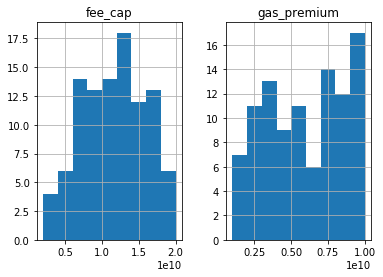

In [9]:
from math import sqrt

def create_df_from_demand(demand):
    gas_premium = pd.Series([tx.gas_premium for tx in demand])
    fee_cap = pd.Series([tx.fee_cap for tx in demand])
    return pd.DataFrame({ 'gas_premium': gas_premium, 'fee_cap': fee_cap })

demand = []
for i in range(100):
    gas_premium = randint(1, 10) * 1000000000
    fee_cap = gas_premium + randint(1, 10) * 1000000000
    demand += [Transaction(
        gas_premium = gas_premium,
        gas_used = 21000,
        fee_cap = fee_cap
    )]
    
demand_df = create_df_from_demand(demand)
demand_df.hist(bins = 9)

The intuition behind these distributions is the following:

- `gas_premium` is obtained by throwing a ten-sided dice.
- To get `fee_cap`, we throw another ten-sided dice and add the result to the `gas_premium` we obtained.

We should find that `gas_premium` is somewhat uniformly distributed over 1 to 9 Gwei, while `fee_cap` looks more like a normal distribution (high chance of getting average values ~ 8-9, low chances of getting extreme values).

Since our average `fee_cap` will be close to 8 or 9 Gwei, let's start the `basefee` in our simulations to 10 Gwei. When a transaction sets its `fee_cap` lower than the prevailing `basefee`, it cannot be included in a block, since it is not willing to pay enough.

This time, we'll create a `Block` class to record the history of transactions getting in.

In [10]:
class Block():
    def __init__(self, txs):
        self.txs = txs

In [11]:
def is_valid(tx, basefee):
    return tx.fee_cap >= basefee

def include_valid_txs(params, step, sL, s):
    demand = s["demand"]
    basefee = s["basefee"]
    miner_gains = 0
    txs_included = []
    
    for tx in demand:
        if not is_valid(tx, basefee):
            continue
            
        gas_price = min([basefee + tx.gas_premium, tx.fee_cap])
        fee = gas_price * tx.gas_used
        txs_included += [tx]
        
    assert miner_gains >= 0
    return ({ "block": Block(txs = txs_included) })

This means we need to change our last state update.

In [12]:
def update_basefee(params, step, sL, s, _input):
    block = _input["block"]
    gas_used = sum([tx.gas_used for tx in block.txs])
    delta = gas_used - constants["TARGET_GAS_USED"]
    basefee = s["basefee"]
    new_basefee = basefee + basefee * delta // constants["TARGET_GAS_USED"] // constants["BASEFEE_MAX_CHANGE_DENOMINATOR"]
    return ("basefee", new_basefee)

We'll also record the latest block in the state.

In [13]:
def record_latest_block(params, step, sL, s, _input):
    block = _input["block"]
    return ("latest_block", block)

 We'll assume for now that transactions which fail to get included just disappear, so a completely fresh new demand spawns for every block.

In [14]:
%%capture

psub = [{
    "policies": {},
    "variables": {
        "demand": update_demand_variable # step 1
    }
}, {
    "policies": {
        "action": include_valid_txs # step 2
    },
    "variables": {
        "basefee": update_basefee, # step 3
        "latest_block": record_latest_block
    }
}]

initial_conditions = {
    "basefee": 10000000000,
    "demand": [],
    "latest_block": Block(txs=[])
}

simulation_parameters = {
    'T': range(100),
    'N': 1,
    'M': {}
}

config = Configuration(initial_state=initial_conditions,
                       partial_state_update_blocks=psub,
                       sim_config=simulation_parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results
df = pd.DataFrame(raw_result)

Let's check how the basefee evolves.

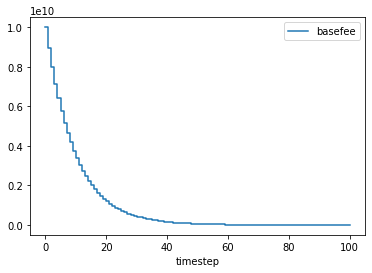

In [15]:
df.plot('timestep', ['basefee'])

As before, the basefee starts from high and progressively decreases, since blocks are not quite meeting their gas target. Let's see how many transactions get in each block.

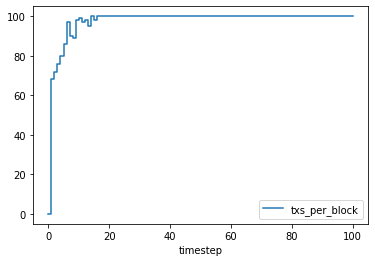

In [16]:
df["txs_per_block"] = df.latest_block.apply(
    lambda block: len(block.txs)
)
df.plot("timestep", "txs_per_block")

The randomness is due to how we sample a new demand each step, but the trend is clear: as the basefee decreases, more and more transactions get in!

### Pricing out

So far we've only seen examples of a gas supply far in excess of the demand. Let's now see how the mechanism reacts when too many transactions are trying to get in.

There are tradeoffs for block producers when including transactions. The heavier the block (as in, the more transactions included), the greater the time for this block to be broadcasted over the P2P network of producers. This may not be such a problem in the eth2 instantiation of Proof-of-Stake, where your slot is "reserved" (see for instance our [_Beacon Runner_](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner/beacon_runner.ipynb)) but in usual Proof-of-Work-backed consensus algorithms, being late to broadcast your block could mean that someone else was able to broadcast theirs, in which case your block won't be included in the canonical chain. This issue is mitigated by Ethereum's uncle mechanism in eth1.

We'll make an assumption here that block producers would allow their blocks to contain 20% over the gas target. That target being set currently at 10M in our `constants`, this means producers would allow blocks with 12M used gas. In practice, the size of the block (in bytes) is not in perfect relationship with the amount of gas used by the block, having more to do with the transaction size (in bytes). But since all our transactions are homogeneous, each using 21K gas, we can circumvent this issue. So blocks in the next simulation may feature up to 12M / 21K = 571 transactions (let's keep 570), while targeting 476 transactions (10M / 21K). Let's update our demand to reflect that, spawning 10,000 transactions each step.

In [17]:
from random import uniform

def update_demand_variable(params, step, sL, s, _input):
    basefee = s["basefee"]
    demand = []
    for i in range(10000):
        gas_premium = uniform(1, 11) * 1000000000
        fee_cap = gas_premium + uniform(1, 11) * 1000000000
        demand += [Transaction(
            gas_premium = gas_premium,
            gas_used = 21000,
            fee_cap = fee_cap
        )]
    return ("demand", demand)

Now block producers must choose which transactions to include. We'll rank transactions in order of their (decreasing) gas premium, since this is the bounty producers are getting out them.

In [18]:
def include_valid_txs(params, step, sL, s):
    demand = s["demand"]
    basefee = s["basefee"]
    miner_gains = 0
    txs_included = []
    sorted_demand = sorted(demand, key = lambda tx: -tx.gas_premium)
    filtered_demand = [tx for tx in sorted_demand if is_valid(tx, basefee)]
    included_transactions = filtered_demand[0:570]
    
    return ({ "block": Block(txs = included_transactions) })

Simulate it...

In [19]:
%%capture
psub = [{
    "policies": {},
    "variables": {
        "demand": update_demand_variable # step 1
    }
}, {
    "policies": {
        "action": include_valid_txs # step 2
    },
    "variables": {
        "basefee": update_basefee, # step 3
        "latest_block": record_latest_block # bonus step
    }
}]

initial_conditions = {
    "basefee": 10000000000,
    "demand": [],
    "latest_block": Block(txs=[])
}

simulation_parameters = {
    'T': range(50),
    'N': 1,
    'M': {}
}

config = Configuration(initial_state=initial_conditions,
                       partial_state_update_blocks=psub,
                       sim_config=simulation_parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results
df = pd.DataFrame(raw_result)

Let's plot the basefee.

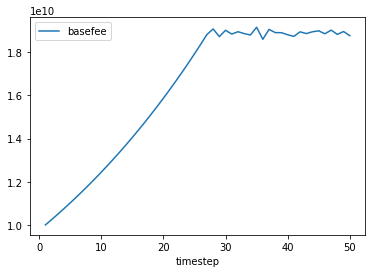

In [20]:
df[df.substep == 1].plot('timestep', ['basefee'])

Is that Mt. Fuji? Basefee stabilises around 19 Gwei, with oscillations due to the randomness of our demand. We can see why by inspecting how many valid transactions don't make it in the block.

Since we generate 10,000 transactions for each block with uniform distribution between 1 and 11 for `gas_premium`, we should expect (in the probabilistic sense) that our 476 most juiciest transactions (measured by `gas_premium`) will have a `gas_premium` of at least 10.524 Gwei. On the other hand, block producers must make sure that the `fee_cap` is enough to cover the `basefee`, so they can't be too picky either and might have to choose transactions that have a high enough `fee_cap`, regardless of their `gas_premium`. Over time then, the average premium decreases, as seen in the following plot:

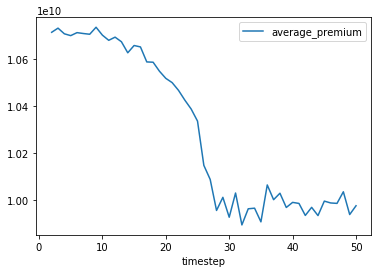

In [21]:
df["average_premium"] = df.latest_block.apply(
    lambda block: 0 if len(block.txs) == 0 else float(sum([tx.gas_premium for tx in block.txs])) / len(block.txs)
)
df[(df.timestep > 1) & (df.substep == 1)].plot("timestep", "average_premium")

Let's check the percentage of _valid_ transactions (i.e., `tx.fee_cap > basefee`) which are not included in the block.

In [23]:
df["previous_basefee"] = df.basefee.shift(1)
df["txs_per_block"] = df.latest_block.apply(
    lambda block: len(block.txs)
)
df["valid_transactions"] = df.apply(
    lambda row: len([tx for tx in row.demand if is_valid(tx, row.previous_basefee)]), axis=1
)
df["fraction_priced_out"] = df.apply(
    lambda row: 0 if row.valid_transactions == 0 else (1 - float(row.txs_per_block) / float(row.valid_transactions)) * 100, axis=1
)

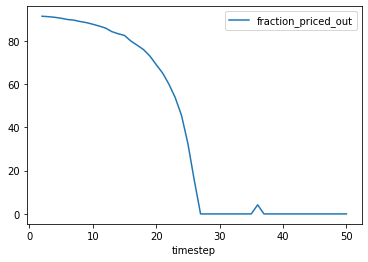

In [24]:
df[(df.timestep > 1) & (df.substep == 2)].plot("timestep", "fraction_priced_out")

That number goes to zero pretty fast, since basefee increases and more and more transactions become invalid. How about the gas used by the blocks?

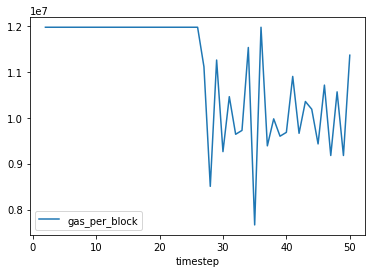

In [25]:
df["gas_per_block"] = df.latest_block.apply(
    lambda block: sum([tx.gas_used for tx in block.txs])
)
df[(df.timestep > 1) & (df.substep == 2)].plot("timestep", "gas_per_block")

We get close to 10M gas per block around the 20th block, which is the target we had set. Victory!

## A more realistic demand

Let's summarise what we have done so far. We assume an _exogenous_ demand (i.e., we set it outside of our model, as a parameter). For now, this demand is really simple: people only want to use the chain to do a transfer, which uses 21,000 units of gas. Given the demand that they observe, block producers select which candidate transactions to include in their blocks. Since the demand is much lower than the actual target supply of gas (we have a demand of 100 transactions, 21,000 gas each, so 2,100,000 gas per block, far from the 10,000,000 target gas set in `constants`), in our simple model block producers are not strategic and simply include all known transactions. The premium (or "tip") in all transactions is set at 1 Gwei, which means that each block producer receives 100 Gwei in transaction fees for each block.

This doesn't tell us much about our mechanism though. We would like instead to study how a more realistic demand for gas will change the behaviour of the basefee and the transaction fee market. For that, it is useful to glean some insights into how the demand behaved historically. Of course, we do not directly have access to this historical demand --- to do so, we would have needed to monitor every change of the mempool over time. What we do have access to though is the history of _included_ transactions in blocks, including the gas price and total fee they paid to get in.

Since that fee was determined by the first-price auction mechanism, we cannot completely expect that the realised demand under a new mechanism will be the same. Maybe our EIP-1559 fee market is really good at coping with congestion and doesn't incent users to be strategic about their bidding, the way they were under the auction mechamism, leading to big price spikes during particularly juicy ICOs or caring for furry beings. In that case, the realised demand observed with the auction won't be a very good prediction for the demand under EIP-1559. Yet, out of the box this will be a much better approximation than making up numbers.

The second motivation is to make the demand _endogeneous_, i.e., model how the demand evolves, instead of generating sample demands based on historical prices. It is clear that the demand does not come out of nowhere: _exogenous_ events such as specific demand shocks (e.g., an ICO, a fun game, spikes of trading activity due to a nasty virus) or endogenous events such as the level of congestion and prices all affect the demand for gas. We may be able to infer just what makes the demand tick from these historical samples. So, instead of "imitating" past transactions, we could simulate the demand behaviour based on exogenous we define and endogenous events we record.

(Note on this draft: I am still in the process of collecting past transaction records.)

## Strategic concerns

A different, orthogonal axis of analysis consists in looking at the micro-economic incentives of all _players_ involved in the transaction fee market. Specifically, we would really like to make sure that block producers cannot _game_ the EIP-1559 mechanism. Assuming a rational model for block producers (meaning they would act in a way to maximise their profits from the block producing), it seems clear from the get-go that producers will have an incentive to keep the size of the tip (relative to the basefee) as high as possible. How can that affect the mechanism?

But users may be strategic too, deciding to delay their transaction if they expect the market to clear and basefee (or total expected fee) to be lower in the future. How do these strategic concerns interact?

### Block producer censorship

Is the following an equilibrium? For some value $f$ (in Gwei):

- Block producers never include a transaction with tip lower than $f$.
- If a block producer is seen to have included a transaction with tip lower than $f$, the block is orphaned.

## System dynamics

We write out EIP-1559 as a dynamical system. Given

- $b(0)$: the basefee at $t=0$,
- $g$: a target gas per block,
- $G$: the max gas limit per block, and
- $d$: the basefee max change denominator $d$,

we observe two dynamical processes:

- $b(t)$ is the basefee at time $t \in \mathbb{N}$.
- $g(t)$ is the total gas used by the block at time $t$, $g(t) \in [0, G]$.

This yields the following state dynamics:

$$ b(t+1) = b(t) + b(t) \frac{g(t) - c}{cd} = b(t) \Big(1 + \frac{g(t) - c}{cd} \Big) $$

Note in the expression above that the closer $g(t)$ is to $c$, the closer $g(t) - c$ is to zero, in which case the basefee at $t+1$ is equal to the basefee at $t$ (no change).